### Notebook to look at isoslices of a control volume over the TXLA shelf. We're specifically looking at the isohalines with the maximum mixing and tracer transport. Plots are relatively sloppy and mainly show that as the shelf break occurs @ h = 50m, bottom temperature drops signficantly to ~15-20 C and maximum tracer transport occurs roughly @ s = 36 g/kg. This explains the 'two' matter masses seen in the TS_TEF notebook. 

In [3]:
import numpy as np
import xgcm
from xgcm import Grid
from xhistogram.xarray import histogram
import xarray as xr
import xroms
from scipy import signal
import glob
import functions #the .py file that contains all the relevant functions
from datetime import datetime

import warnings
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 12})

import warnings
warnings.filterwarnings("ignore")
from celluloid import Camera
from IPython.display import HTML

In [4]:
paths = glob.glob('../../../dylan.schlichting/TXLA_Outputs/parent/2010/ocean_his_00*.nc')

ds = xroms.open_mfnetcdf(paths, 
                         chunks = {'ocean_time':1})
ds, grid = xroms.roms_dataset(ds, 
                              Vtransform = None)

xislice=slice(260,381) 
etaslice=slice(47,149)

### Plot the control volume location

In [5]:
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])
states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

In [9]:
np.sqrt(31334)

177.01412373028316

In [8]:
dA = (ds.dx*ds.dy).isel(eta_rho = etaslice, xi_rho = xislice)
dA.sum().values/1E6

31334.174100887365

In [83]:
latrho

array([[27.95234307, 27.95861294, 27.96480743, ..., 28.32777228,
        28.3292671 , 28.33075726],
       [27.9646817 , 27.97099179, 27.97722623, ..., 28.34239437,
        28.34388231, 28.34536516],
       [27.97697955, 27.98332948, 27.98960353, ..., 28.35691781,
        28.35839847, 28.35987362],
       ...,
       [29.01589146, 29.0253799 , 29.03476807, ..., 29.46184494,
        29.46112824, 29.46037588],
       [29.02654229, 29.03606637, 29.04548991, ..., 29.47235931,
        29.4716016 , 29.47080786],
       [29.03724257, 29.04680264, 29.05626192, ..., 29.48291296,
        29.4821136 , 29.48127783]])

In [103]:
latrho[::11,:]

<xarray.DataArray 'lat_rho' (eta_rho: 10, xi_rho: 121)>
dask.array<getitem, shape=(10, 121), dtype=float64, chunksize=(10, 121), chunktype=numpy.ndarray>
Coordinates:
    lon_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(10, 121), meta=np.ndarray>
    lat_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(10, 121), meta=np.ndarray>
  * xi_rho   (xi_rho) int64 260 261 262 263 264 265 ... 375 376 377 378 379 380
  * eta_rho  (eta_rho) int64 47 58 69 80 91 102 113 124 135 146
Attributes:
    long_name:      latitude of RHO-points
    units:          degree_north
    standard_name:  latitude
    field:          lat_rho, scalar
    grid:           <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * c...

In [120]:
102/9

11.333333333333334

In [ ]:
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(10,4), dpi = 100)
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.PlateCarree(central_longitude=-85.0))

lonnn = grid.interp(ds.lon_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)
latnn = grid.interp(ds.lat_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)

hlevs = [10, 20, 30, 50, 100]  # isobath contour depths

mappable = ax.pcolormesh(ds.lon_rho, ds.lat_rho, ds.salt[0,-1], 
                         cmap = cmo.haline, 
                         transform = cartopy.crs.PlateCarree(),
                         vmin = 15, vmax = 37)

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -88.5, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, )
ax.add_feature(cfeature.BORDERS, linestyle='-', )
ax.add_feature(cartopy.feature.RIVERS, linewidth = 2)
ax.set_aspect('auto')

cax = fig.add_axes([0.14, 0.93, 0.4, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Surface Salinity [g kg$^{-1}$]', fontsize=14, color='0.2')
cb.ax.tick_params(labelsize=14, length=2, color='0.2', labelcolor='0.2')

#Plot isobaths and label the contours
CS = ax.contour(ds.lon_rho, ds.lat_rho, ds.h, hlevs, 
                colors='1', transform=ccrs.PlateCarree(), 
                inline = 1, linewidths=1)
ax.clabel(CS, fmt = '%1.0f', fontsize = 10)
ax.tick_params(axis='y', labelsize=12)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.left_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False

#Box boundaries
# ax.plot(lonnn[0,:], latnn[0,:], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
# ax.plot(lonnn[:,0], latnn[:,0], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[:,-1], latnn[:,-1], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[-1,:], latnn[-1,:], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)

latrho = ds.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice)
lonrho = ds.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice)


for i in range(4):
    ax.plot(lonrho[:,0+33*i],latrho[:,0+33*i], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
for i in range(3):
    ax.plot(lonrho[0+34*i,:],latrho[0+34*i,:], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
# ax.plot(lonrho[::11,::11],latrho[::11,:11], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)

### Calculate the depth of the 35 psu isohaline

In [9]:
saltslice = ds.salt.isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time = slice('2010-06', '2010-08'))
zrhoslice = ds.z_rho.isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time = slice('2010-06', '2010-08'))

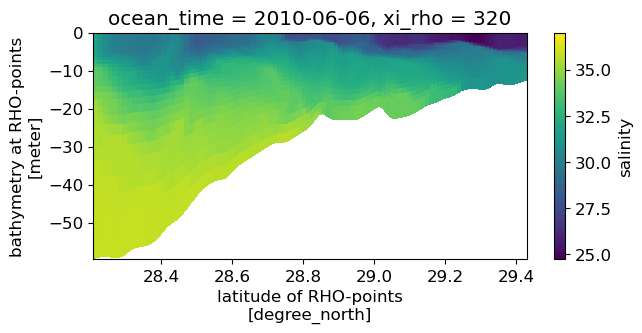

In [140]:
fig, ax = plt.subplots(1, figsize = (7,3), dpi = 100)
saltslice.isel(ocean_time = 120, xi_rho = 60).plot(x = 'lat_rho', y = 'z_rho0', vmax = 37)

In [136]:
ds.dz

<xarray.DataArray 'dz' (ocean_time: 8760, s_rho: 30, eta_rho: 191, xi_rho: 671)>
dask.array<sub, shape=(8760, 30, 191, 671), dtype=float64, chunksize=(1, 30, 191, 671), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 671), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2010-01-01T01:00:00 ... 2011-01-01
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 664 665 666 667 668 669 670
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 184 185 186 187 188 189 190
    z_rho       (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 30, 191, 671), meta=np.ndarray>
    z_rho0      (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(30, 191, 671), meta=np.ndarray>
Attributes:
    grid:     <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * center ...

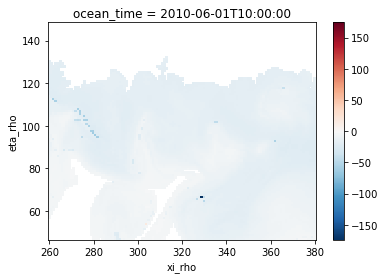

In [31]:
s33 = xroms.utilities.xisoslice(saltslice[10], 33, zrhoslice[10], 's_rho')
s33.plot()

### Max salt mixing for the entire summer occurs at 28.44 psu

In [10]:
s28jun = xroms.utilities.xisoslice(saltslice.sel(ocean_time = '2010-06'), 28.4, zrhoslice.sel(ocean_time = '2010-06'), 's_rho')
s28jul = xroms.utilities.xisoslice(saltslice.sel(ocean_time = '2010-07'), 28.4, zrhoslice.sel(ocean_time = '2010-07'), 's_rho')
s28aug = xroms.utilities.xisoslice(saltslice.sel(ocean_time = '2010-08'), 28.4, zrhoslice.sel(ocean_time = '2010-08'), 's_rho')

In [61]:
s36jun = xroms.utilities.xisoslice(saltslice.sel(ocean_time = '2010-06'), 36.04, zrhoslice.sel(ocean_time = '2010-06'), 's_rho')
s36jul = xroms.utilities.xisoslice(saltslice.sel(ocean_time = '2010-07'), 36.04, zrhoslice.sel(ocean_time = '2010-07'), 's_rho')
s36aug = xroms.utilities.xisoslice(saltslice.sel(ocean_time = '2010-08'), 36.04, zrhoslice.sel(ocean_time = '2010-08'), 's_rho')

In [41]:
# s28junm = s28jun.mean('ocean_time').load()
s28julm = s28jul.mean('ocean_time').load()
s28augm = s28aug.mean('ocean_time').load()

In [134]:
s36jun[120].max().values

array(469.62630902)

Text(0.5, 1.0, '2010-06-06T00:00:00.000000000')

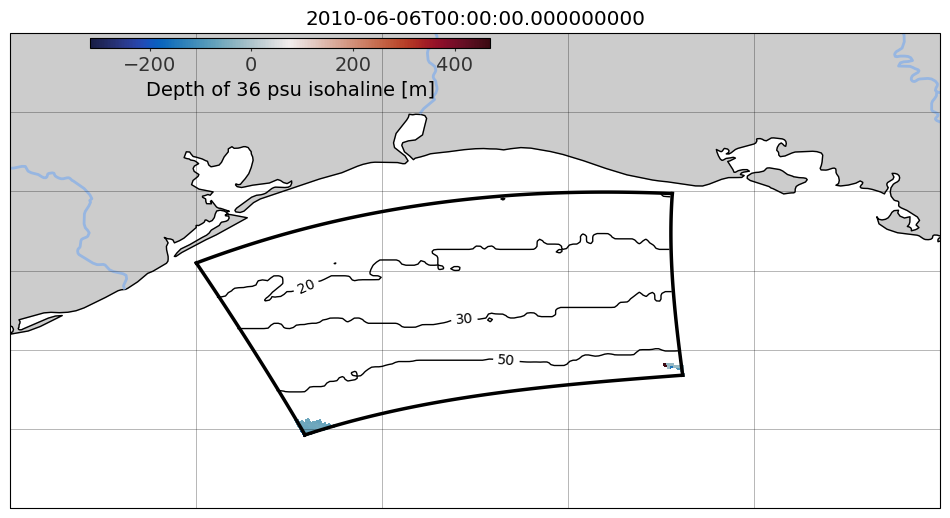

In [131]:
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize=(10,5), dpi = 100)
camera = Camera(fig)
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.PlateCarree(central_longitude=-85.0))

lonnn = grid.interp(ds.lon_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)
latnn = grid.interp(ds.lat_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)

hlevs = [10, 20, 30, 50, 100]  # isobath contour depths

t = s36jun[120]#.sel(ocean_time = '2010-06-10 12:00')
levels = MaxNLocator(nbins=10).tick_values(-100, 0)
mappable = ax.pcolormesh(lonnn, latnn, t, 
                         cmap = cmo.balance, 
                         transform = cartopy.crs.PlateCarree(),
                         )

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -91, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, )
ax.add_feature(cfeature.BORDERS, linestyle='-', )
ax.add_feature(cartopy.feature.RIVERS, linewidth = 2)
ax.set_aspect('auto')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False

CS = ax.contour(ds.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice), 
                ds.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice), 
                ds.h.isel(eta_rho = etaslice, xi_rho = xislice), hlevs, 
                colors='k', transform=ccrs.PlateCarree(), 
                inline = 1, linewidths=1)
ax.clabel(CS, fmt = '%1.0f', fontsize = 10)

cax = fig.add_axes([0.14, 0.93, 0.4, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Depth of 36 psu isohaline [m]', fontsize=14, color='k')
cb.ax.tick_params(labelsize=14, length=2, color='0.2', labelcolor='0.2')

ax.plot(lonnn[0,:], latnn[0,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[:,0], latnn[:,0], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[:,-1], latnn[:,-1], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[-1,:], latnn[-1,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)

ax.set_title(str(t.ocean_time.values))

Text(0.5, 1.0, '2010-08-20T12:00:00.000000000')

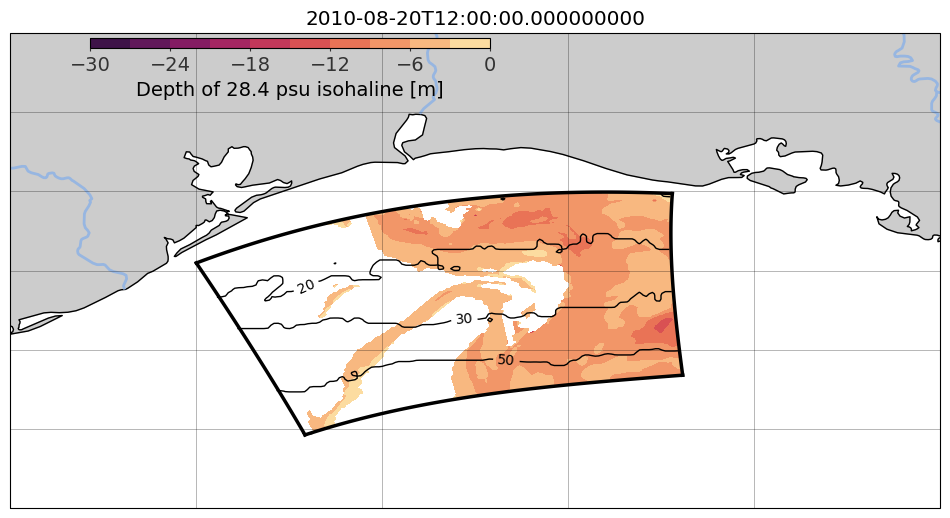

In [60]:
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize=(10,5), dpi = 100)
camera = Camera(fig)
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.PlateCarree(central_longitude=-85.0))

lonnn = grid.interp(ds.lon_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)
latnn = grid.interp(ds.lat_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)

hlevs = [10, 20, 30, 50, 100]  # isobath contour depths

t = s28aug.sel(ocean_time = '2010-08-20 12:00')
levels = MaxNLocator(nbins=10).tick_values(-30, 0)
mappable = ax.contourf(lonnn, latnn, t, 
                         cmap = cmo.matter_r, 
                         transform = cartopy.crs.PlateCarree(),
                         levels = levels)

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -91, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, )
ax.add_feature(cfeature.BORDERS, linestyle='-', )
ax.add_feature(cartopy.feature.RIVERS, linewidth = 2)
ax.set_aspect('auto')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False

CS = ax.contour(ds.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice), 
                ds.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice), 
                ds.h.isel(eta_rho = etaslice, xi_rho = xislice), hlevs, 
                colors='k', transform=ccrs.PlateCarree(), 
                inline = 1, linewidths=1)
ax.clabel(CS, fmt = '%1.0f', fontsize = 10)

cax = fig.add_axes([0.14, 0.93, 0.4, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Depth of 28.4 psu isohaline [m]', fontsize=14, color='k')
cb.ax.tick_params(labelsize=14, length=2, color='0.2', labelcolor='0.2')

ax.plot(lonnn[0,:], latnn[0,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[:,0], latnn[:,0], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[:,-1], latnn[:,-1], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[-1,:], latnn[-1,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)

ax.set_title(str(t.ocean_time.values))

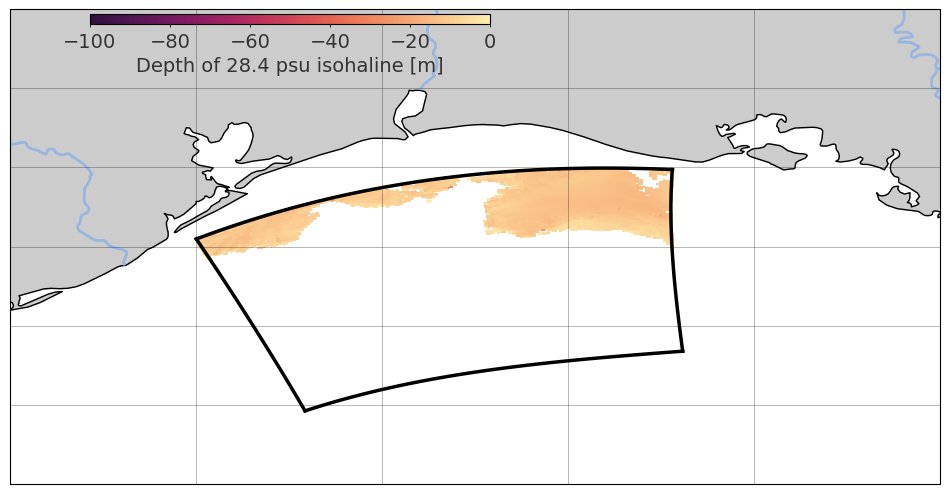

In [19]:
fig = plt.figure(figsize=(10,5), dpi = 100)
camera = Camera(fig)
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.PlateCarree(central_longitude=-85.0))

lonnn = grid.interp(ds.lon_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)
latnn = grid.interp(ds.lat_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)

hlevs = [10, 20, 30, 50, 100]  # isobath contour depths

ims = []
mappable = ax.pcolormesh(lonnn, latnn, s28m[-1], 
                         cmap = cmo.matter_r, 
                         transform = cartopy.crs.PlateCarree(),
                         vmin = -100, vmax = 0)

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -91, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, )
ax.add_feature(cfeature.BORDERS, linestyle='-', )
ax.add_feature(cartopy.feature.RIVERS, linewidth = 2)
ax.set_aspect('auto')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False

cax = fig.add_axes([0.14, 0.93, 0.4, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Depth of 28.4 psu isohaline [m]', fontsize=14, color='0.2')
cb.ax.tick_params(labelsize=14, length=2, color='0.2', labelcolor='0.2')

ax.plot(lonnn[0,:], latnn[0,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[:,0], latnn[:,0], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[:,-1], latnn[:,-1], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[-1,:], latnn[-1,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)

In [84]:
dzrho0 = ds.z_rho0.diff('s_rho')
dV0 = ds.dx*ds.dy*dzrho0

dV = dV0.isel(eta_rho = etaslice, xi_rho = xislice).sum('s_rho')

In [106]:
dV.max().values/10**7

26.90336703468279

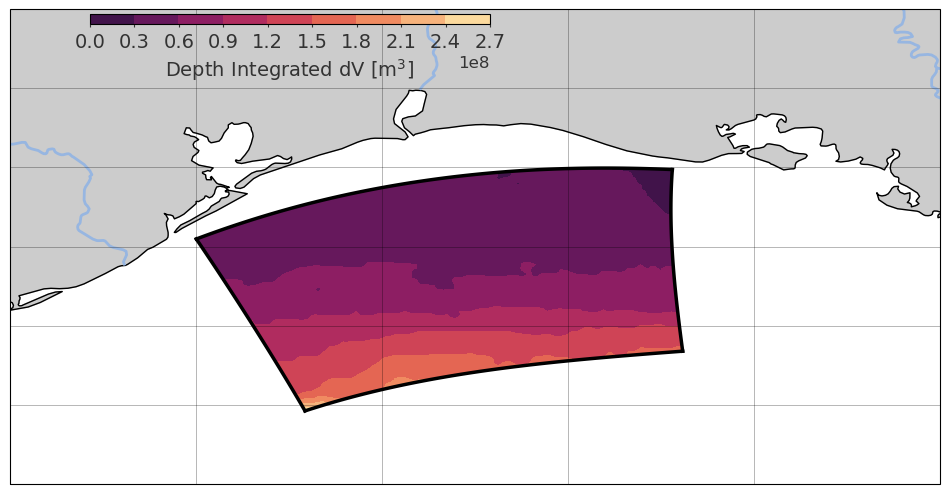

In [103]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(10,5), dpi = 100)
camera = Camera(fig)
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.PlateCarree(central_longitude=-85.0))

lonnn = grid.interp(ds.lon_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)
latnn = grid.interp(ds.lat_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)

hlevs = [10, 20, 30, 50, 100]  # isobath contour depths
levels = MaxNLocator(nbins=10).tick_values(dV.min().values, dV.max().values)
mappable = ax.contourf(lonnn, latnn, dV, 
                         cmap = cmo.matter_r, 
                         transform = cartopy.crs.PlateCarree(),
                       levels = levels
                         )

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -91, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, )
ax.add_feature(cfeature.BORDERS, linestyle='-', )
ax.add_feature(cartopy.feature.RIVERS, linewidth = 2)
ax.set_aspect('auto')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False

cax = fig.add_axes([0.14, 0.93, 0.4, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Depth Integrated dV [m$^3$]', fontsize=14, color='0.2')
cb.ax.tick_params(labelsize=14, length=2, color='0.2', labelcolor='0.2')

ax.plot(lonnn[0,:], latnn[0,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[:,0], latnn[:,0], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[:,-1], latnn[:,-1], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[-1,:], latnn[-1,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)


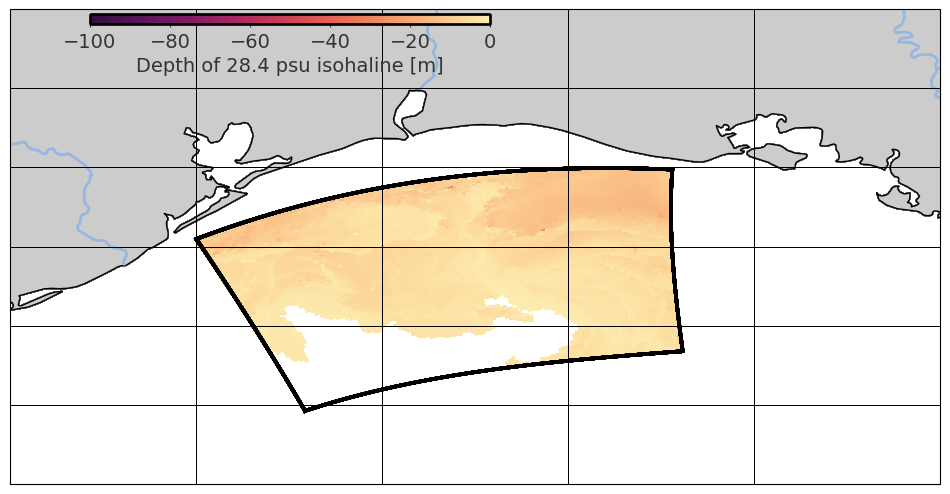

In [22]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(10,5), dpi = 100)
camera = Camera(fig)
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.PlateCarree(central_longitude=-85.0))

lonnn = grid.interp(ds.lon_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)
latnn = grid.interp(ds.lat_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)

hlevs = [10, 20, 30, 50, 100]  # isobath contour depths

ims = []
for i in range(len(s28m.ocean_time[:])):
    mappable = ax.pcolormesh(lonnn, latnn, s28m[i], 
                             cmap = cmo.matter_r, 
                             transform = cartopy.crs.PlateCarree(),
                             vmin = -100, vmax = 0)

    gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
    ax.set_extent([-96, -91, 27.5, 30.5], ccrs.PlateCarree())
    ax.add_feature(land_10m, facecolor='0.8')
    ax.coastlines(resolution='10m')  
    ax.add_feature(states_provinces, )
    ax.add_feature(cfeature.BORDERS, linestyle='-', )
    ax.add_feature(cartopy.feature.RIVERS, linewidth = 2)
    ax.set_aspect('auto')
    gl.right_labels = False
    gl.top_labels = False
    gl.bottom_labels = False
    gl.left_labels = False

    cax = fig.add_axes([0.14, 0.93, 0.4, 0.02]) 
    cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
    cb.set_label(r'Depth of 28.4 psu isohaline [m]', fontsize=14, color='0.2')
    cb.ax.tick_params(labelsize=14, length=2, color='0.2', labelcolor='0.2')

    ax.plot(lonnn[0,:], latnn[0,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
    ax.plot(lonnn[:,0], latnn[:,0], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
    ax.plot(lonnn[:,-1], latnn[:,-1], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
    ax.plot(lonnn[-1,:], latnn[-1,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
    
    camera.snap()

In [23]:
animation = camera.animate()
plt.close()
animation.save('s28_dmean_jun.gif', fps = 6)

In [5]:
# import matplotlib.animation as animation
# ani = animation.ArtistAnimation(fig, ims, interval=1, blit=True,
#                                 repeat_delay=1000)

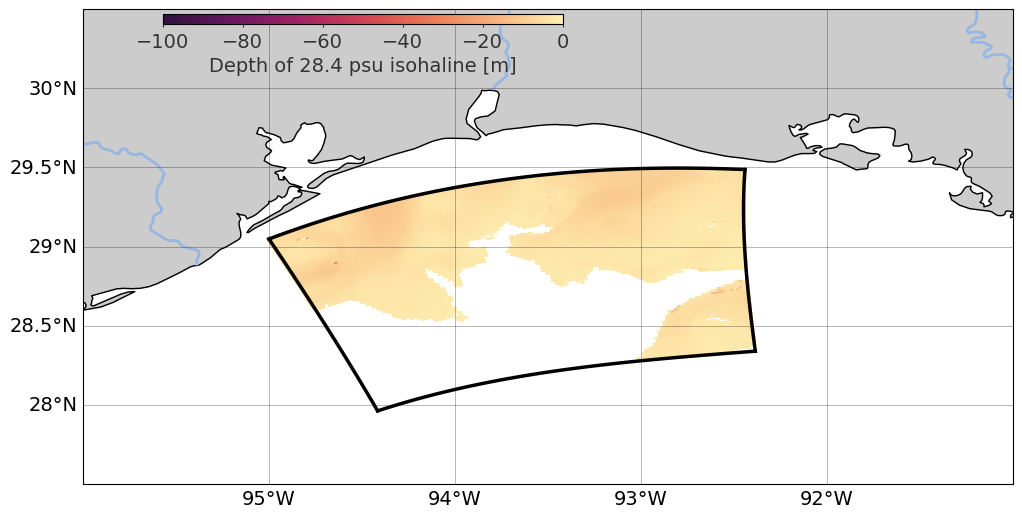

In [57]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10,5), dpi = 100)
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.PlateCarree(central_longitude=-85.0))

lonnn = grid.interp(ds.lon_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)
latnn = grid.interp(ds.lat_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)

hlevs = [10, 20, 30, 50, 100]  # isobath contour depths

mappable = ax.pcolormesh(lonnn, latnn, s33jun[0], 
                         cmap = cmo.matter_r, 
                         transform = cartopy.crs.PlateCarree(),
                         vmin = -100, vmax = 0)

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -91, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, )
ax.add_feature(cfeature.BORDERS, linestyle='-', )
ax.add_feature(cartopy.feature.RIVERS, linewidth = 2)
ax.set_aspect('auto')
gl.right_labels = False
gl.top_labels = False

cax = fig.add_axes([0.14, 0.93, 0.4, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Depth of 28.4 psu isohaline [m]', fontsize=14, color='0.2')
cb.ax.tick_params(labelsize=14, length=2, color='0.2', labelcolor='0.2')

ax.plot(lonnn[0,:], latnn[0,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[:,0], latnn[:,0], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[:,-1], latnn[:,-1], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[-1,:], latnn[-1,:], 'k', lw=2.5,transform = cartopy.crs.PlateCarree(),)

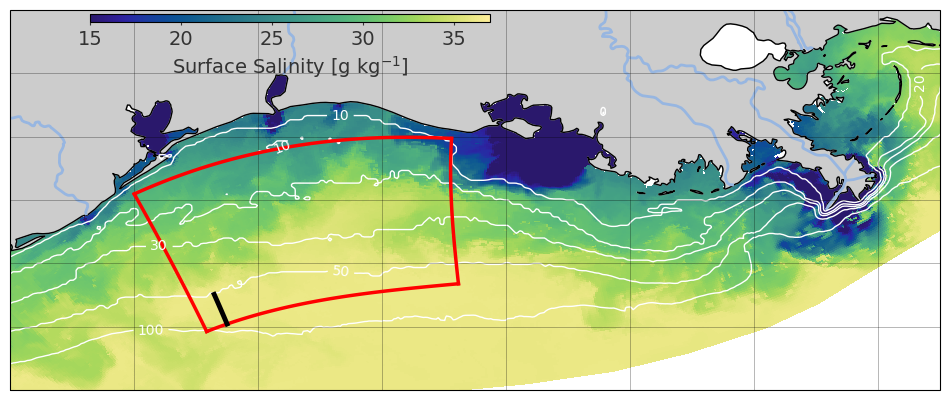

In [144]:
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(10,4), dpi = 100)
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.PlateCarree(central_longitude=-85.0))

lonnn = grid.interp(ds.lon_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)
latnn = grid.interp(ds.lat_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)

hlevs = [10, 20, 30, 50, 100]  # isobath contour depths

mappable = ax.pcolormesh(ds.lon_rho, ds.lat_rho, ds.salt[0,-1], 
                         cmap = cmo.haline, 
                         transform = cartopy.crs.PlateCarree(),
                         vmin = 15, vmax = 37)

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -88.5, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, )
ax.add_feature(cfeature.BORDERS, linestyle='-', )
ax.add_feature(cartopy.feature.RIVERS, linewidth = 2)
ax.set_aspect('auto')

cax = fig.add_axes([0.14, 0.93, 0.4, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Surface Salinity [g kg$^{-1}$]', fontsize=14, color='0.2')
cb.ax.tick_params(labelsize=14, length=2, color='0.2', labelcolor='0.2')

#Plot isobaths and label the contours
CS = ax.contour(ds.lon_rho, ds.lat_rho, ds.h, hlevs, 
                colors='1', transform=ccrs.PlateCarree(), 
                inline = 1, linewidths=1)
ax.clabel(CS, fmt = '%1.0f', fontsize = 10)
ax.tick_params(axis='y', labelsize=12)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.left_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False

#Box boundaries
ax.plot(lonnn[0,:], latnn[0,:], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[:,0], latnn[:,0], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[:,-1], latnn[:,-1], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)
ax.plot(lonnn[-1,:], latnn[-1,:], 'r', lw=2.5,transform = cartopy.crs.PlateCarree(),)

ax.plot(lonnn[:20,10], latnn[:20,10], 'k', lw=3.5,transform = cartopy.crs.PlateCarree(),)

In [147]:
lonnn

<xarray.DataArray 'mul-913e9921bfe86a353511d96b38993383' (eta_v: 102, xi_u: 121)>
dask.array<getitem, shape=(102, 121), dtype=float64, chunksize=(102, 121), chunktype=numpy.ndarray>
Coordinates:
  * eta_v    (eta_v) int64 47 48 49 50 51 52 53 ... 142 143 144 145 146 147 148
  * xi_u     (xi_u) int64 260 261 262 263 264 265 ... 375 376 377 378 379 380

In [235]:
tempslice = ds.temp.isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time = slice('2010-06', '2010-08'))

tmean = tempslice[:,0].mean('ocean_time').load()

In [250]:
saltslice = ds.salt.isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time = slice('2010-06', '2010-08'))

smean = saltslice[:,0].mean('ocean_time').load()

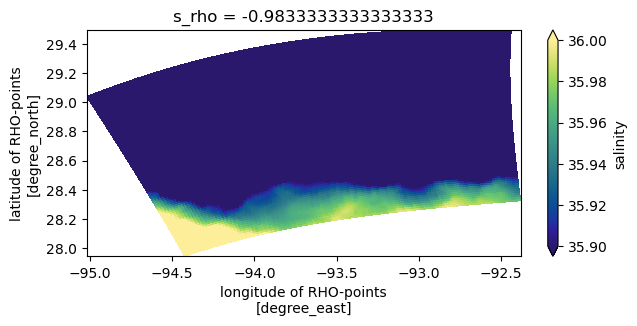

In [267]:
fig, ax = plt.subplots(1, figsize = (7,3), dpi = 100)
smean.plot(x = 'lon_rho', y = 'lat_rho', cmap = cmo.haline, vmin = 35.9, vmax = 36)

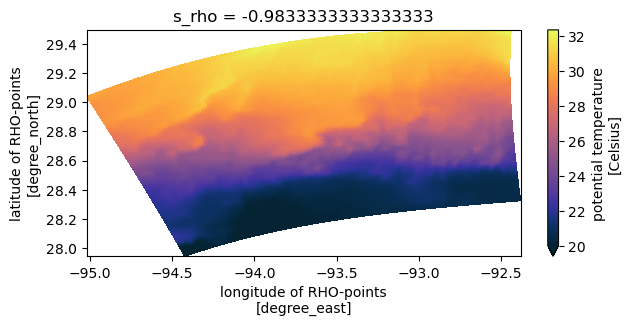

In [236]:
fig, ax = plt.subplots(1, figsize = (7,3), dpi = 100)
tmean.plot(x = 'lon_rho', y = 'lat_rho', cmap = cmo.thermal, vmin = 20)

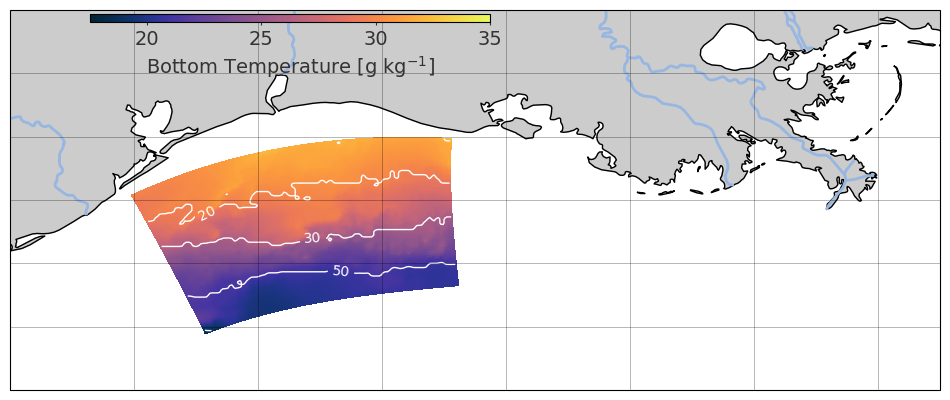

In [249]:
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(10,4), dpi = 100)
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.PlateCarree(central_longitude=-85.0))

lonnn = grid.interp(ds.lon_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)
latnn = grid.interp(ds.lat_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)

hlevs = [10, 20, 30, 50, 100]  # isobath contour depths

mappable = ax.pcolormesh(tmean.lon_rho,tmean.lat_rho, tmean, 
                         cmap = cmo.thermal, 
                         transform = cartopy.crs.PlateCarree(),
                         vmin = 17.5, vmax = 35)

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -88.5, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, )
ax.add_feature(cfeature.BORDERS, linestyle='-', )
ax.add_feature(cartopy.feature.RIVERS, linewidth = 2)
ax.set_aspect('auto')

cax = fig.add_axes([0.14, 0.93, 0.4, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Bottom Temperature [g kg$^{-1}$]', fontsize=14, color='0.2')
cb.ax.tick_params(labelsize=14, length=2, color='0.2', labelcolor='0.2')

# Plot isobaths and label the contours
CS = ax.contour(ds.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice), 
                ds.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice), 
                ds.h.isel(eta_rho = etaslice, xi_rho = xislice), 
                hlevs, 
                colors='1', transform=ccrs.PlateCarree(), 
                inline = 1, linewidths=1)
ax.clabel(CS, fmt = '%1.0f', fontsize = 10)
ax.tick_params(axis='y', labelsize=12)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.left_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False

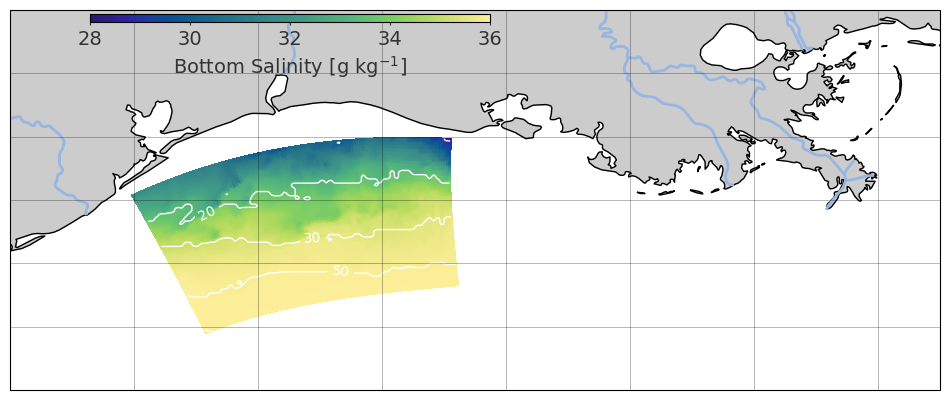

In [268]:
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(10,4), dpi = 100)
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.PlateCarree(central_longitude=-85.0))

lonnn = grid.interp(ds.lon_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)
latnn = grid.interp(ds.lat_u, 'Y', boundary = 'extrapolate').isel(eta_v = etaslice, xi_u = xislice)

hlevs = [10, 20, 30, 50, 100]  # isobath contour depths

mappable = ax.pcolormesh(tmean.lon_rho,tmean.lat_rho, smean, 
                         cmap = cmo.haline, 
                         transform = cartopy.crs.PlateCarree(),
                         vmin = 28, vmax = 36)

gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-96, -88.5, 27.5, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, )
ax.add_feature(cfeature.BORDERS, linestyle='-', )
ax.add_feature(cartopy.feature.RIVERS, linewidth = 2)
ax.set_aspect('auto')

cax = fig.add_axes([0.14, 0.93, 0.4, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Bottom Salinity [g kg$^{-1}$]', fontsize=14, color='0.2')
cb.ax.tick_params(labelsize=14, length=2, color='0.2', labelcolor='0.2')

# Plot isobaths and label the contours
CS = ax.contour(ds.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice), 
                ds.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice), 
                ds.h.isel(eta_rho = etaslice, xi_rho = xislice), 
                hlevs, 
                colors='1', transform=ccrs.PlateCarree(), 
                inline = 1, linewidths=1)
ax.clabel(CS, fmt = '%1.0f', fontsize = 10)
ax.tick_params(axis='y', labelsize=12)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.left_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.top_labels = False